In [1]:
import numpy as np
import pandas as pd
from constants import *
from phe import *
from waves import *
import series as s

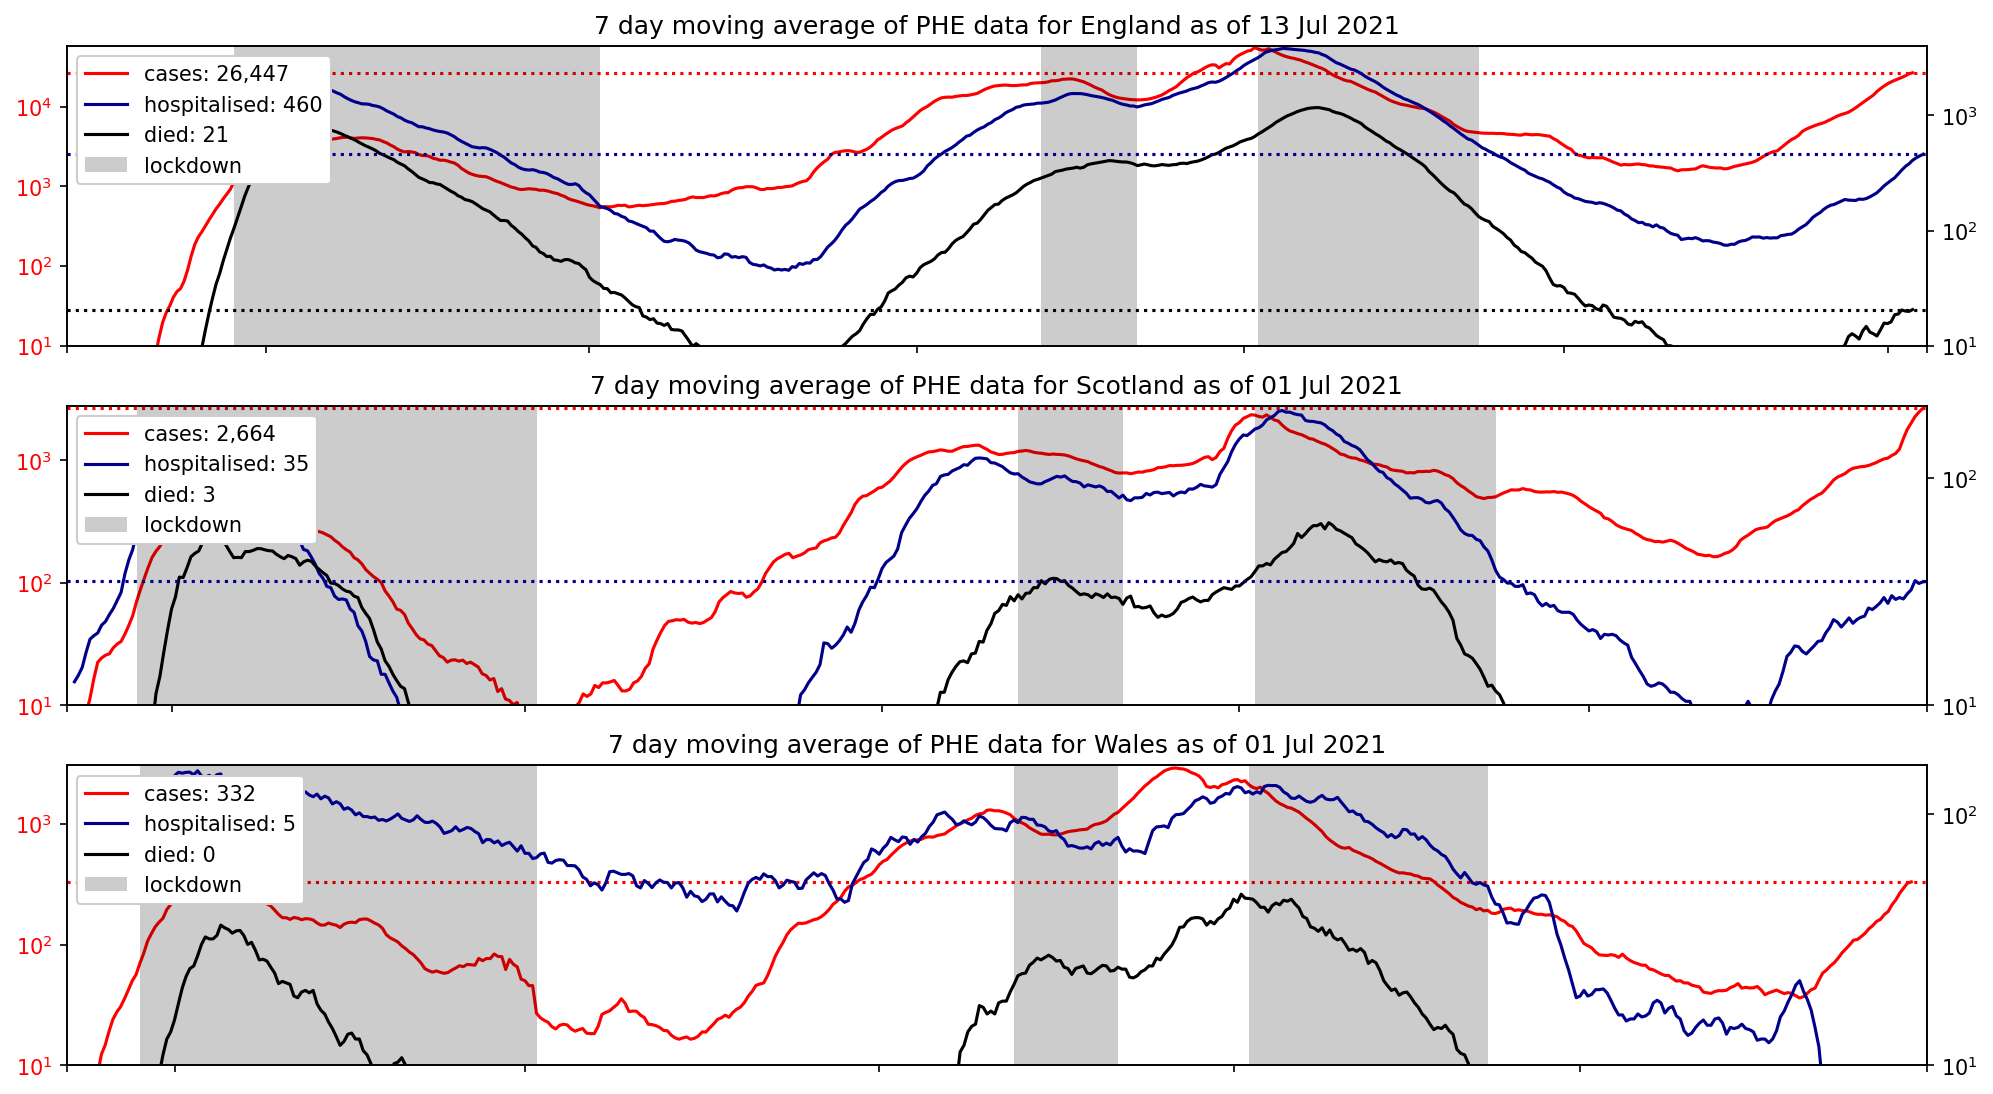

In [6]:
fig, rows = plt.subplots(nrows=3, ncols=1, figsize=(16, 9), dpi=150)
fig.set_facecolor('white')

for nation_name, row in zip(('england', 'scotland', 'wales'), rows):
    plot_summary(earliest_date='2020-02-01', show_latest='lines', log=True, ax=row, nation=nation_name, 
                 x_labels=nation == 'wales',
                 left_series=(s.new_cases_sum,),
                 right_series=(s.new_admissions_sum, s.new_deaths_sum))

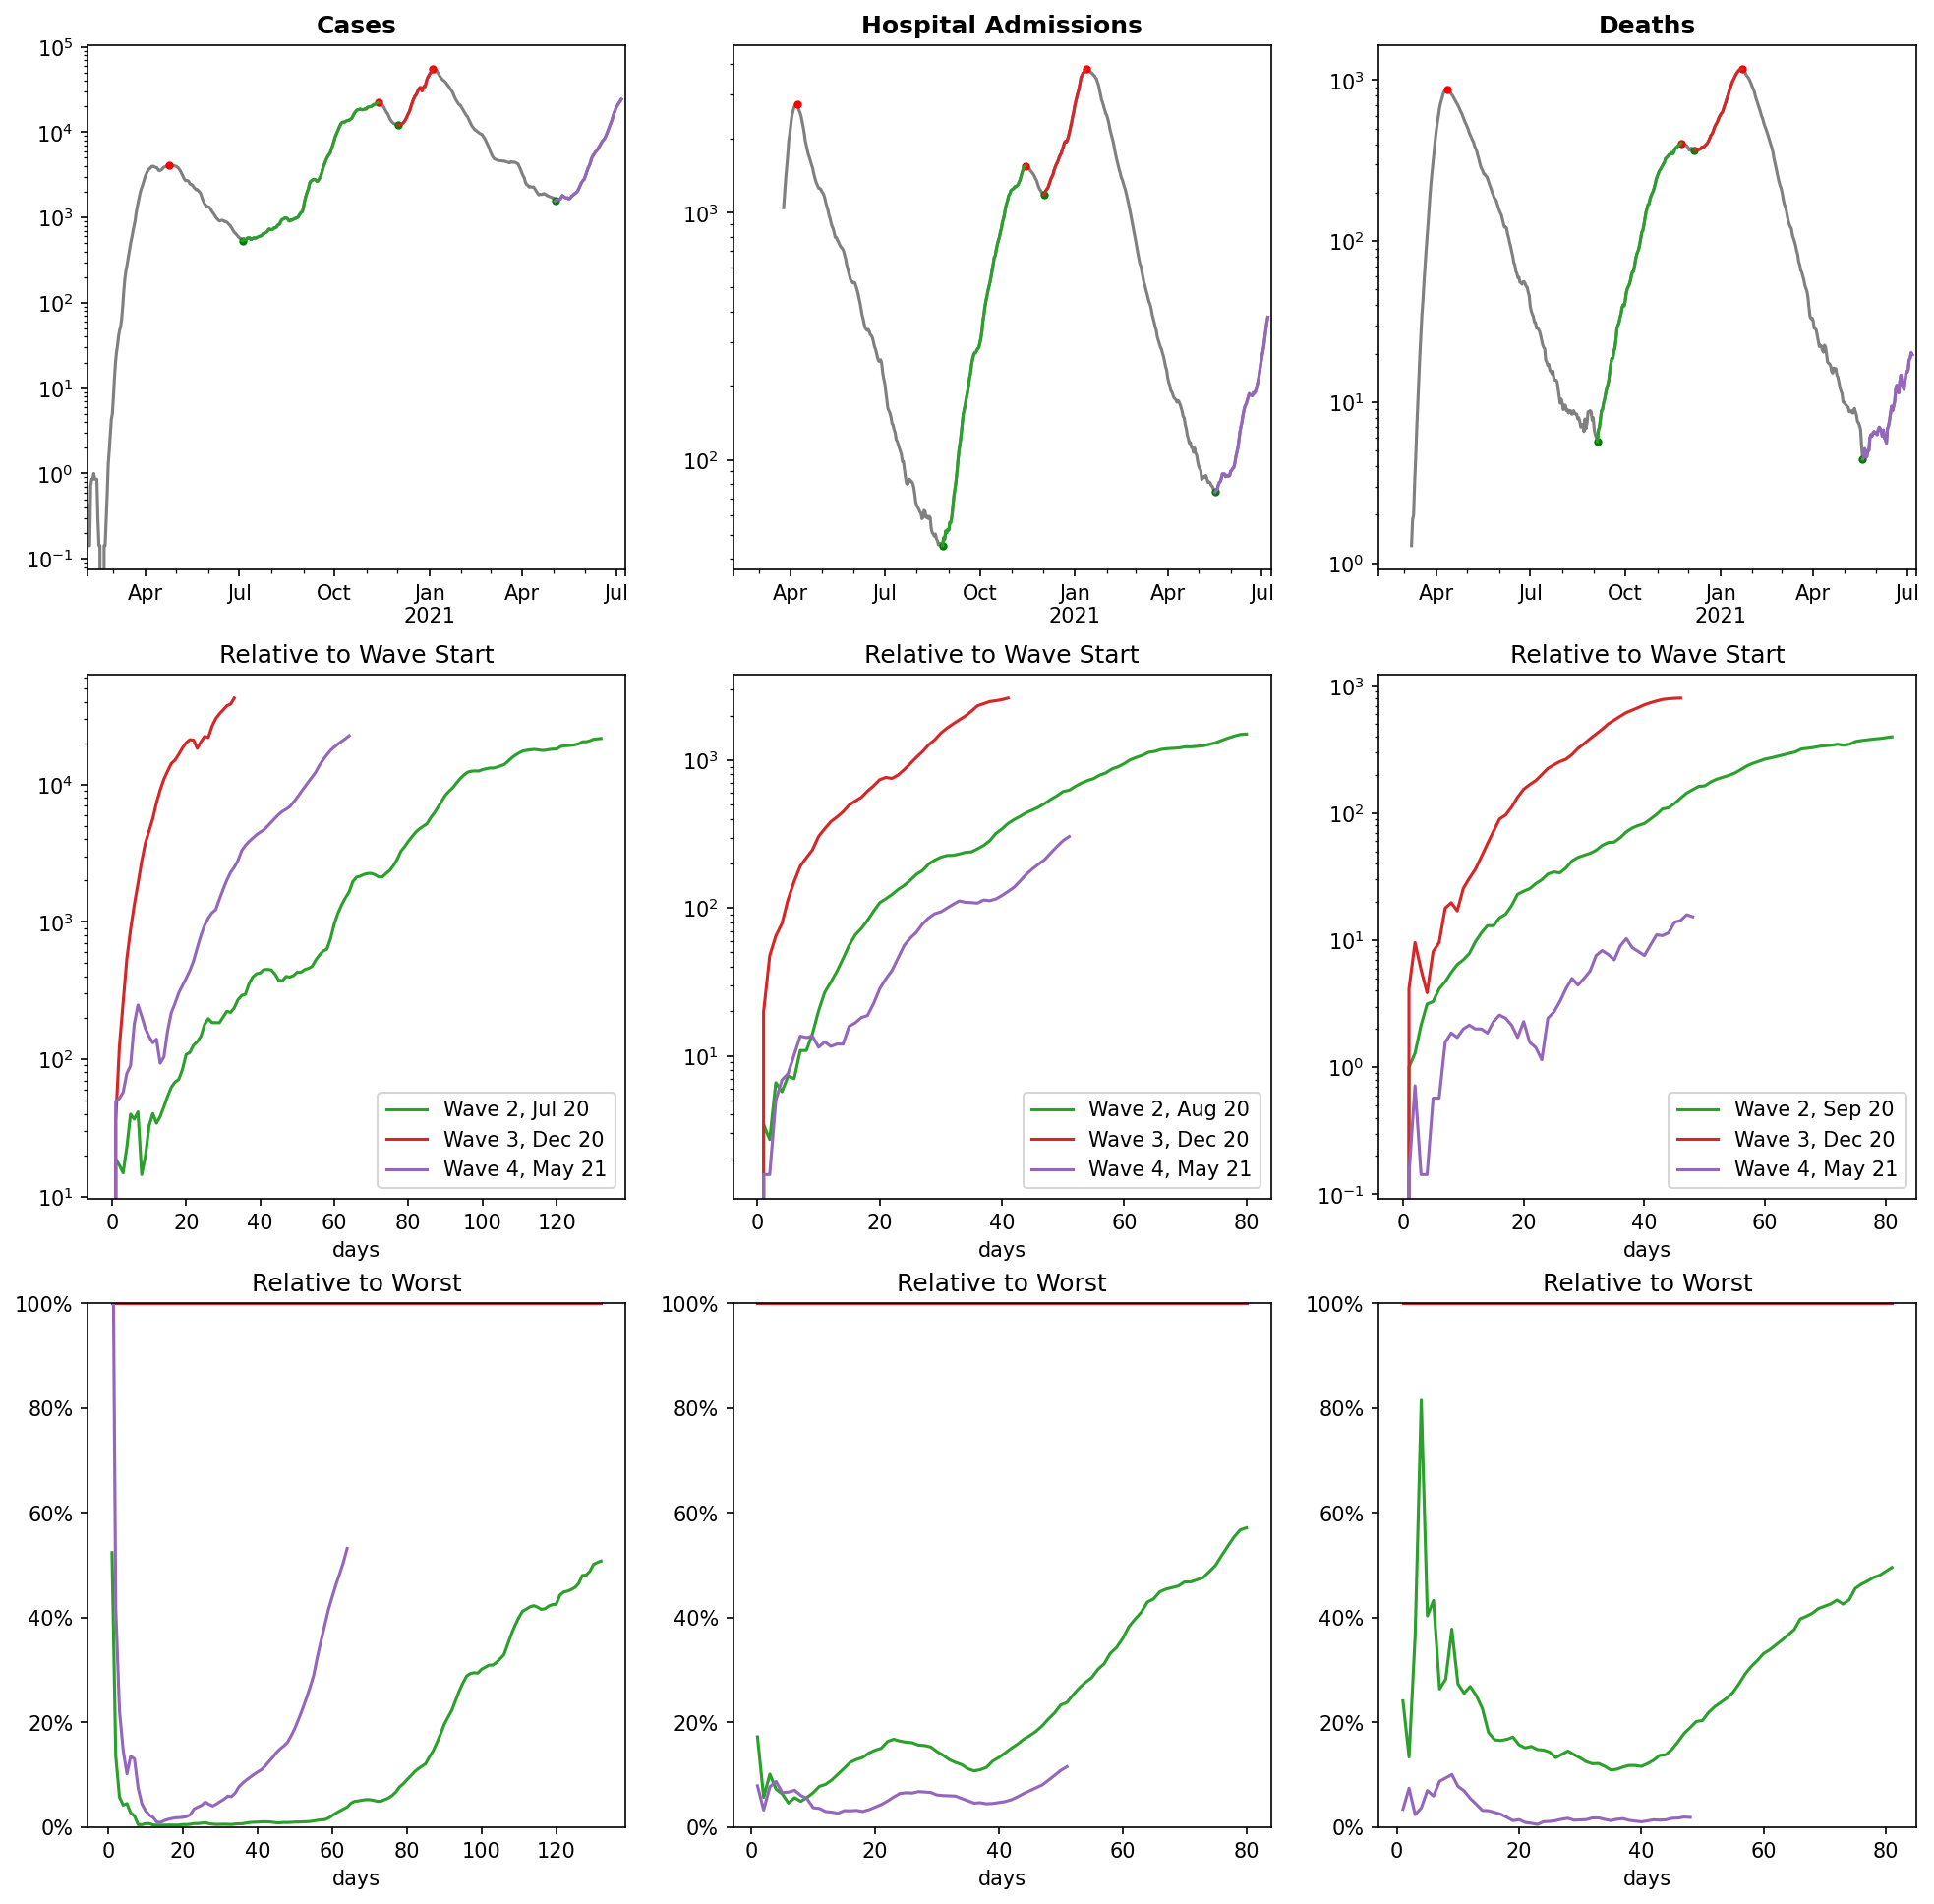

In [3]:
plot_all(figsize=(16, 16))

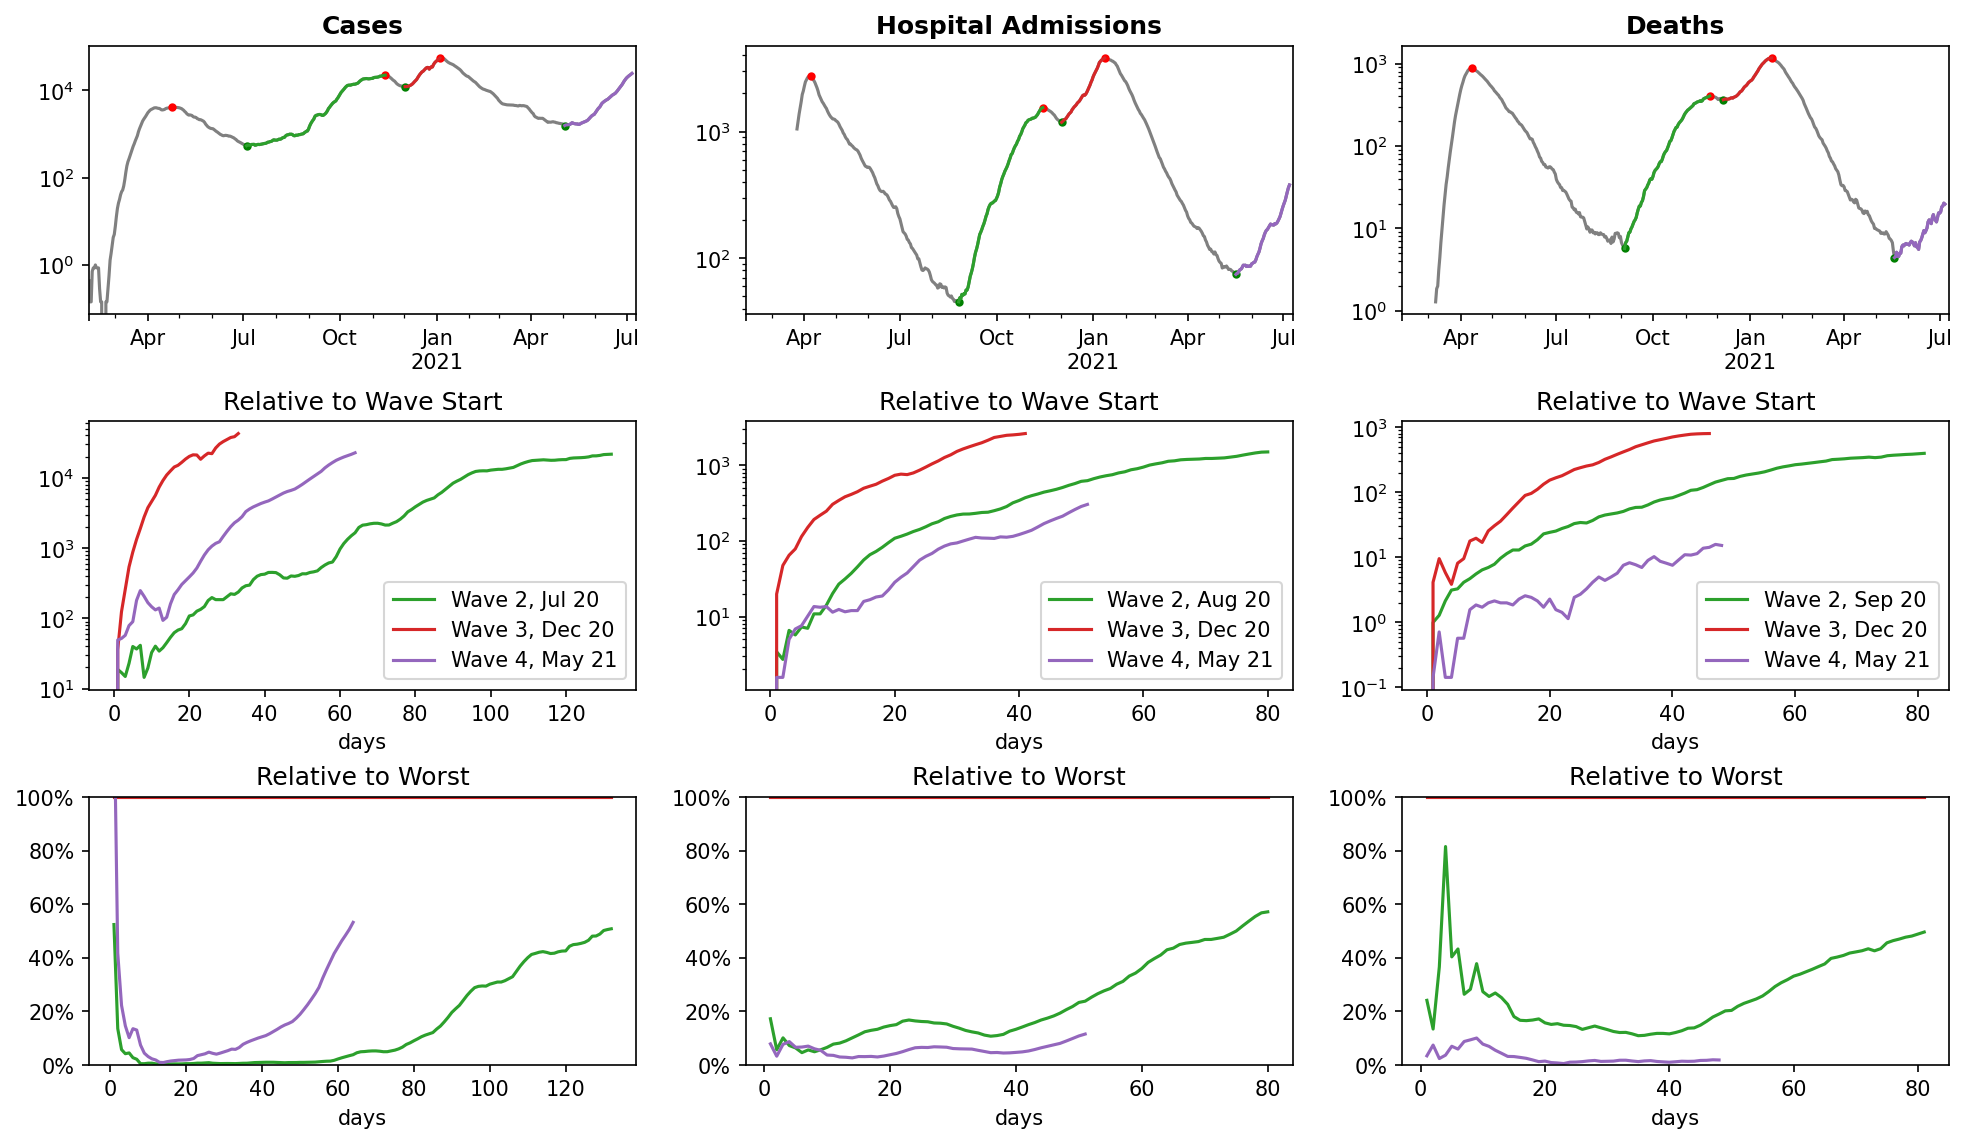

In [4]:
plot_all(figsize=(16, 9), hspace=0.4)

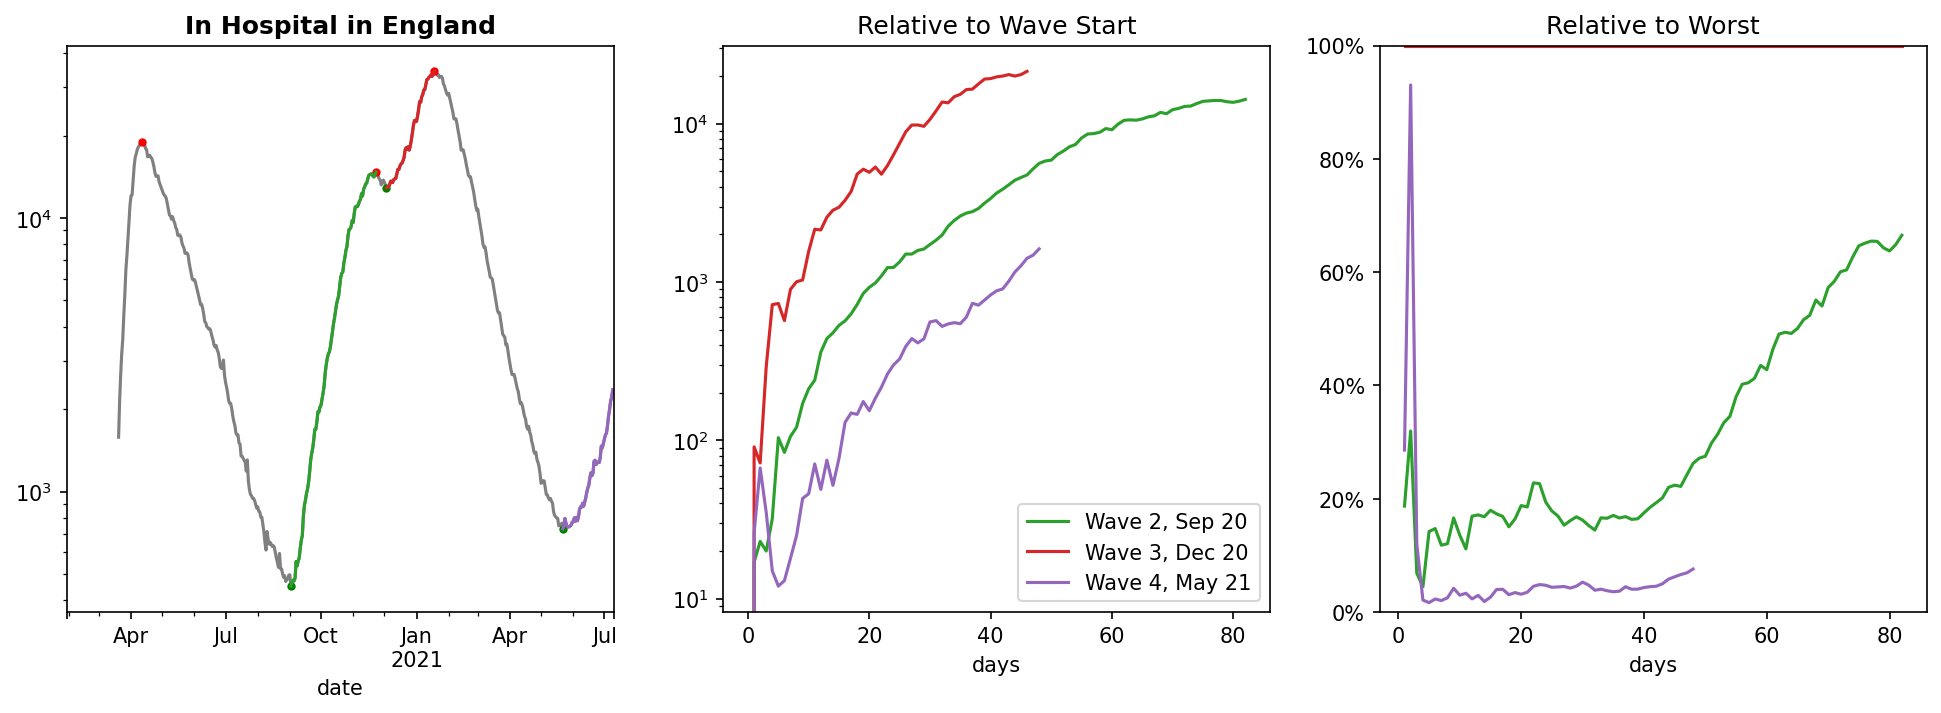

In [5]:
data, _ = best_data(area_type=nation, areas=[england], metric=in_hospital, date_index=True)
waves(data, in_hospital, 'In Hospital in England')